In [1]:
import numpy as np
import os
os.chdir('/Volume/VAD/UAADF/')
import torch
from arguments import parser
from torch.utils.data import DataLoader
from datasets import create_dataset
from accelerate import Accelerator
import matplotlib.pyplot as plt 
import seaborn as sns 
from utils import img_show, img_cvt

from main import torch_seed
import random 

from refinement.sampler import SubsetSequentialSampler
from refinement.refinement import Refinementer


torch_seed(0)
torch.autograd.set_detect_anomaly(True)
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

def prepare(dataset, class_name, anomaly_ratio, baseline,weight_method):
    dataset = 'pc_mvtecad' if dataset == 'mvtecad' else 'pc_mvtecloco'
    default_setting = f'./configs/benchmark/{dataset}.yaml'
    cfg = parser(jupyter=True, default_setting = default_setting)
    cfg.DATASET.class_name = class_name 
    cfg.DATASET.params.anomaly_ratio = anomaly_ratio
    cfg.DATASET.params.baseline = baseline 
    cfg.MODEL.params.weight_method = weight_method 
    
    trainset, testset = create_dataset(
    dataset_name  = cfg.DATASET.dataset_name,
    datadir       = cfg.DATASET.datadir,
    class_name    = cfg.DATASET.class_name,
    img_size      = cfg.DATASET.img_size,
    mean          = cfg.DATASET.mean,
    std           = cfg.DATASET.std,
    aug_info      = cfg.DATASET.aug_info,
    **cfg.DATASET.get('params',{})
)

    method            = cfg.MODEL.method
    backbone          = cfg.MODEL.backbone
    model_params      = cfg.MODEL.get('params',{})

    batch_size       = cfg.DATASET.batch_size
    test_batch_size  = cfg.DATASET.test_batch_size
    num_workers      = cfg.DATASET.num_workers

    # # define train dataloader
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = batch_size,
        num_workers = num_workers,
        shuffle     = False
    )

    # define test dataloader
    testloader = DataLoader(
        dataset     = testset,
        batch_size  = test_batch_size,
        shuffle     = False,
        num_workers = num_workers
    )

    refinement = Refinementer(
            model          = __import__('models').__dict__[method](
                            backbone = backbone,
                            **model_params
                            ),
            n_query        = cfg.REFINEMENT.n_query,
            dataset        = trainset,
            unrefined_idx  = np.ones(len(trainset)).astype(np.bool8),
            batch_size     = batch_size,
            test_transform = testset.transform,
            num_workers    = num_workers
        )
    model = refinement.init_model()
    device = cfg.MODEL.params.device
    
    output = {}
    output['trainloader'], output['testloader'], output['model'], output['device']  = trainloader, testloader, model, device
    
    return output 

def train(trainloader, device, model):
    for imgs, labels, gts in trainloader:
        output = model(imgs.to(device))
        loss = model.criterion(output)
    model.fit()
    
def evaluation(testloader, device, model, loco = False):
    from utils.metrics import MetricCalculator, loco_auroc

    model.eval()
    img_level = MetricCalculator(metric_list = ['auroc','average_precision','confusion_matrix'])
    pix_level = MetricCalculator(metric_list = ['auroc','average_precision','confusion_matrix','aupro'])

    results = {} 
    for idx, (images, labels, gts) in enumerate(testloader):
        
        # predict
        if model.__class__.__name__ in ['PatchCore']:
            score, score_map = model.get_score_map(images)
        else:
            with torch.no_grad():
                outputs = model(images)   
                score_map = model.get_score_map(outputs).detach().cpu()
                score = score_map.reshape(score_map.shape[0],-1).max(-1)[0]
                
        # Stack Scoring for metrics 
        pix_level.update(score_map,gts.type(torch.int))
        img_level.update(score, labels.type(torch.int))
        
    p_results = pix_level.compute()
    i_results = img_level.compute()
    
    
    if loco:
        results['loco_auroc'] = loco_auroc(pix_level,testloader)
        results['loco_auroc'] = loco_auroc(img_level,testloader)    
        return p_results, i_results, results 
    else:         
        return p_results, i_results

def patch_scoring(testloader, model):
    self = model 
    score_list = [] 
    for imgs, labels, gts in testloader: 
        images = imgs.to(torch.float).to(self.device)
        _ = self.forward_modules.eval()

        with torch.no_grad():
            features, patch_shapes = self._embed(images, provide_patch_shapes=True)
            features = np.asarray(features)

            image_scores, _, indices = self.anomaly_scorer.predict([features])
        
        score_list.append(image_scores)
    score_list = np.concatenate(score_list)
    return score_list 

In [2]:
capsule_soft = prepare('mvtecad','capsule',0.0,False,'lof')
capsule_patch = prepare('mvtecad','capsule',0.0,False,'identity')

# train(capsule_soft['trainloader'], capsule_soft['device'], capsule_soft['model'])
# train(capsule_patch['trainloader'], capsule_patch['device'], capsule_patch['model'])

In [3]:
model, trainloader, device = capsule_soft['model'], capsule_soft['trainloader'], capsule_soft['device'] 
for imgs, labels, gts in trainloader:
    output = model(imgs.to(device))
self= model     

import tqdm 
_ = self.forward_modules.eval()

def _image_to_features(input_image):
    with torch.no_grad():
        input_image = input_image.to(torch.float).to(self.device)
        return self._embed(input_image)

features = []
with tqdm.tqdm(self.data, desc="Computing support features...", leave=True) as data_iterator:
    for image in data_iterator:
        if isinstance(image, dict):
            image = image["image"]
        features.append(_image_to_features(image))
        
features = np.concatenate(features, axis=0)    

with torch.no_grad():
    # pdb.set_trace()
    self.feature_shape = self._embed(image.to(torch.float).to(self.device), provide_patch_shapes=True)[1][0]
    patch_weight = self._compute_patch_weight(features) # <- get outlier score 

    # normalization
    # patch_weight = (patch_weight - patch_weight.quantile(0.5, dim=1, keepdim=True)).reshape(-1) + 1

    patch_weight = patch_weight.reshape(-1)
    threshold = torch.quantile(patch_weight, 1 - self.threshold)
    sampling_weight = torch.where(patch_weight > threshold, 0, 1) 
    self.featuresampler.set_sampling_weight(sampling_weight) # <- subsampling data which has outlier score under thresholding
    self.patch_weight = patch_weight.clamp(min=0)
    sample_features, sample_indices = self.featuresampler.run(features)    

Subsampling...: 100%|██████████| 17169/17169 [00:08<00:00, 1915.66it/s]


In [10]:
score_list = patch_scoring(capsule_soft['testloader'],capsule_soft['model'])

In [10]:
from sklearn.manifold import TSNE 

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features[:10,:])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [20]:
np.save('./temp.npy',[tsne_result, sample_indices],allow_pickle=True)

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [2]:
import os 

os.chdir('../')

In [3]:

import numpy as np 
temp2 = np.load('./tsne_result.npy',allow_pickle=True)

In [4]:
tsne_result, sample_indices = temp2

In [7]:
indices = np.arange(len(tsne_result))

In [8]:
import pandas as pd 

indices = indices[pd.Series(indices).apply(lambda x : x not in sample_indices).values]

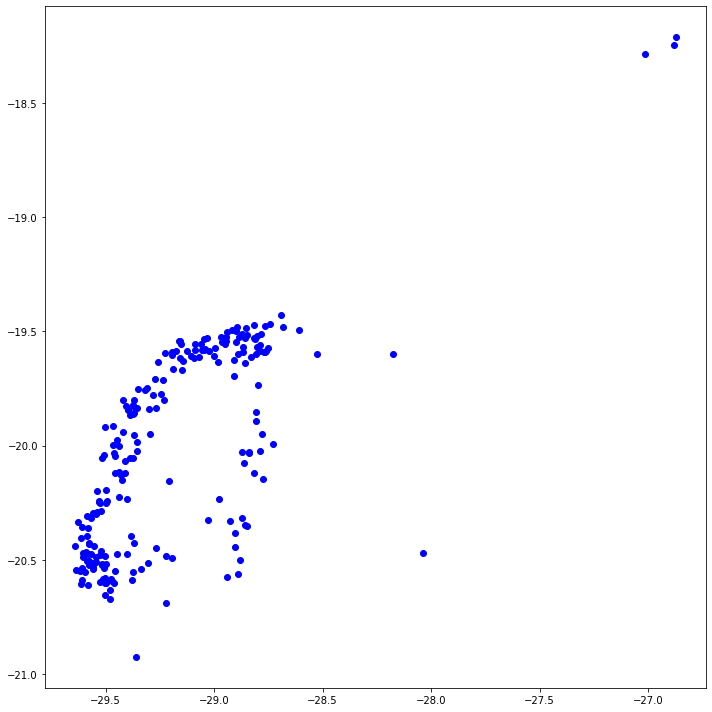

In [44]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))

w = 21
h = 26
plt.scatter(
    tsne_result.reshape(-1,28,28,2)[:,w,h,:][:,0],tsne_result.reshape(-1,28,28,2)[:,w,h,:][:,1],
    c = 'b',
    marker ='o'
)

# plt.scatter(
#     tsne_result[sample_indices][:,0],tsne_result[sample_indices][:,1],
#     c = 'r',
#     marker ='v'
# )
plt.tight_layout()

In [17]:
171696/28/28

219.0

(219, 2)